In [21]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
import time

from causallearn.search.ConstraintBased.PC import pc
from causallearn.utils.cit import kci

from ensemble.epc import epc



def gdata(n):
    """
    Generate data based on a causal graph with nonlinear relationships.

    Args:
        n (int): Number of samples.

    Returns:
        np.ndarray, np.ndarray: Generated data and the causal graph (trueSk).
    """
    trueSk = np.zeros((4, 4), dtype=int)
    for i in range(4):
        for j in range(i + 1, 4):
            e = int(np.random.rand() < 0.5)
            trueSk[i, j] = e
            trueSk[j, i] = e

    X1 = np.random.normal(0, 1, n)
    
    if trueSk[0,1]:
        X2 = np.random.normal(0, 1, n) + np.random.uniform(0, 1, n) * np.sin(X1)
    else:
        X2 = np.random.normal(0, 1, n)
    
    if trueSk[0,2]:
        if trueSk[1,2]:
            X3 = (np.random.normal(0, 1, n) +
                  np.random.uniform(0, 1, n) * np.log1p(np.abs(X2)) +
                  np.random.uniform(0, 1, n) * np.exp(-X1**2))
        else:
            X3 = (np.random.normal(0, 1, n) +
                  np.random.uniform(0, 1, n) * np.exp(-X1**2))
    elif trueSk[1,2]:
        X3 = np.random.normal(0, 1, n) + np.random.uniform(0, 1, n) * np.log1p(np.abs(X2))
    else:
        X3 = np.random.normal(0, 1, n)

    if trueSk[0,3]:
        if trueSk[1,3]:
            if trueSk[2,3]:
                X4 = (np.random.normal(0, 1, n) +
                      np.random.uniform(0, 1, n) * np.sqrt(np.abs(X3)) +
                      np.random.uniform(0, 1, n) * np.sin(X2) +
                      np.random.uniform(0, 1, n) * np.cos(X1))
            else:
                X4 = (np.random.normal(0, 1, n) +
                      np.random.uniform(0, 1, n) * np.sin(X2) +
                      np.random.uniform(0, 1, n) * np.cos(X1))
        elif trueSk[2,3]:
            X4 = (np.random.normal(0, 1, n) +
                  np.random.uniform(0, 1, n) * np.sqrt(np.abs(X3)) +
                  np.random.uniform(0, 1, n) * np.cos(X1))
        else:
            X4 = (np.random.normal(0, 1, n) +
                  np.random.uniform(0, 1, n) * np.cos(X1))
    elif trueSk[1,3]:
        if trueSk[2,3]:
            X4 = (np.random.normal(0, 1, n) +
                  np.random.uniform(0, 1, n) * np.sqrt(np.abs(X3)) +
                  np.random.uniform(0, 1, n) * np.sin(X2))
        else:
            X4 = np.random.normal(0, 1, n) + np.random.uniform(0, 1, n) * np.sin(X2)
    elif trueSk[2,3]:
        X4 = np.random.normal(0, 1, n) + np.random.uniform(0, 1, n) * np.sqrt(np.abs(X3))
    else:
        X4 = np.random.normal(0, 1, n)

    data = np.array([X1, X2, X3, X4]).T
    
    return data, trueSk



def compute_SHD(tureG, estiG):
    """
    cg.G.graph[j,i]=1 and cg.G.graph[i,j]=-1 indicates  i --> j
    cg.G.graph[i,j] = cg.G.graph[j,i] = -1 indicates i --- j
    cg.G.graph[i,j] = cg.G.graph[j,i] = 1 indicates i <-> j
    """
    non = (tureG!=estiG)
    return int(np.sum(non|non.T)/2)


In [22]:
t = 100
n = 1600
res = []

for i in tqdm(range(t), desc="Processing"):
    np.random.seed(i)
    data, trueSk = gdata(n)
    cg = pc(data, 0.1, kci, show_progress=False)
    sk = np.abs(cg.G.graph)
    res.append(compute_SHD(trueSk, sk))

np.mean(res), np.std(res)

Processing: 100%|██████████| 100/100 [30:05<00:00, 18.06s/it]


(0.35, 0.57227615711298)

In [23]:
t = 100
n = 1600
eres = []

for i in tqdm(range(t), desc="Processing"):
    np.random.seed(i)
    data, trueSk = gdata(n)
    ecg = epc(data, 0.4, "Gamma", 8, show_progress=False)
    esk =np.abs(ecg.G.graph)
    eres.append(compute_SHD(trueSk, esk))
np.mean(eres), np.std(eres)

Processing: 100%|██████████| 100/100 [07:25<00:00,  4.46s/it]


(0.41, 0.6179805822192151)

In [24]:
t = 100
n = 1600
ares = []

for i in tqdm(range(t), desc="Processing"):
    np.random.seed(i)
    data, trueSk = gdata(n)
    acg = epc(data, 0.1, "ACAT", 2, show_progress=False)
    ask =np.abs(acg.G.graph)
    ares.append(compute_SHD(trueSk, ask))
np.mean(ares), np.std(ares)

Processing: 100%|██████████| 100/100 [17:11<00:00, 10.32s/it]


(0.24, 0.47159304490206383)

---

In [25]:
t = 100
ress = []
for n in [200,400,800,1200,1600,2000,2400,2800,3200]:
    start_time = time.time()
    res = []
    for i in tqdm(range(t), desc="Processing"):
        np.random.seed(i)
        data, trueSk = gdata(n)
        cg = pc(data, 0.1, kci, show_progress=False)
        sk = np.abs(cg.G.graph)
        res.append(compute_SHD(trueSk, sk))
    end_time = time.time()
    ress.append([np.mean(res), np.std(res), end_time - start_time])
np.array(ress).T

Processing: 100%|██████████| 100/100 [3:55:14<00:00, 141.15s/it] 


array([[1.69000000e+00, 1.07000000e+00, 4.40000000e-01, 4.10000000e-01,
        3.50000000e-01, 1.70000000e-01, 1.90000000e-01, 1.50000000e-01,
        1.70000000e-01],
       [1.05541461e+00, 8.97273648e-01, 6.21610811e-01, 6.01581250e-01,
        5.72276157e-01, 4.25558457e-01, 4.17013189e-01, 4.09267639e-01,
        4.01372645e-01],
       [1.10723710e+01, 6.49714780e+01, 3.12458164e+02, 8.65550668e+02,
        1.69653634e+03, 3.21754112e+03, 5.50240589e+03, 9.00515278e+03,
        1.41149578e+04]])

In [26]:
t = 100
e1ress = []
for n in [200,400,800,1200,1600,2000,2400,2800,3200]:
    start_time = time.time()
    res = []
    for i in tqdm(range(t), desc="Processing"):
        np.random.seed(i)
        data, trueSk = gdata(n)
        cg = epc(data, 0.4, "Gamma", 8, show_progress=False)
        sk = np.abs(cg.G.graph)
        res.append(compute_SHD(trueSk, sk))
    end_time = time.time()
    e1ress.append([np.mean(res), np.std(res), end_time - start_time])
np.array(e1ress).T

Processing: 100%|██████████| 100/100 [26:54<00:00, 16.14s/it]


array([[1.76000000e+00, 1.29000000e+00, 6.70000000e-01, 3.70000000e-01,
        4.10000000e-01, 2.70000000e-01, 1.70000000e-01, 2.10000000e-01,
        2.40000000e-01],
       [1.14995652e+00, 1.04206526e+00, 7.35594997e-01, 5.59553393e-01,
        6.17980582e-01, 4.86929153e-01, 3.75632799e-01, 4.31161223e-01,
        4.27083130e-01],
       [7.00362802e+00, 2.35740969e+01, 1.08036978e+02, 2.61585467e+02,
        4.60808412e+02, 6.82935473e+02, 9.47921544e+02, 1.24290584e+03,
        1.61449742e+03]])

In [27]:
t = 100
e2ress = []
for n in [200,400,800,1200,1600,2000,2400,2800,3200]:
    start_time = time.time()
    res = []
    for i in tqdm(range(t), desc="Processing"):
        np.random.seed(i)
        data, trueSk = gdata(n)
        cg = epc(data, 0.4, "Gamma", int(n/200), show_progress=False)
        sk = np.abs(cg.G.graph)
        res.append(compute_SHD(trueSk, sk))
    end_time = time.time()
    e2ress.append([np.mean(res), np.std(res), end_time - start_time])
np.array(e2ress).T

Processing: 100%|██████████| 100/100 [16:02<00:00,  9.62s/it]


array([[1.45000000e+00, 1.09000000e+00, 6.20000000e-01, 5.90000000e-01,
        4.10000000e-01, 3.00000000e-01, 2.30000000e-01, 2.70000000e-01,
        3.20000000e-01],
       [1.00374299e+00, 1.03048532e+00, 8.69252552e-01, 6.94190176e-01,
        6.17980582e-01, 5.00000000e-01, 5.26402888e-01, 5.26402888e-01,
        4.87442304e-01],
       [5.56569571e+01, 9.30204470e+01, 1.68663692e+02, 3.25736910e+02,
        4.44998141e+02, 5.50591144e+02, 6.63336301e+02, 8.15210137e+02,
        9.62356674e+02]])

In [28]:
t = 100
a1ress = []
for n in [200,400,800,1200,1600,2000,2400,2800,3200]:
    start_time = time.time()
    res = []
    for i in tqdm(range(t), desc="Processing"):
        np.random.seed(i)
        data, trueSk = gdata(n)
        cg = epc(data, 0.1, "ACAT", 2, show_progress=False)
        sk = np.abs(cg.G.graph)
        res.append(compute_SHD(trueSk, sk))
    end_time = time.time()
    a1ress.append([np.mean(res), np.std(res), end_time - start_time])
np.array(a1ress).T

Processing: 100%|██████████| 100/100 [1:21:29<00:00, 48.90s/it]


array([[1.90000000e+00, 1.61000000e+00, 8.10000000e-01, 4.30000000e-01,
        2.40000000e-01, 7.00000000e-02, 1.50000000e-01, 9.00000000e-02,
        4.00000000e-02],
       [1.22065556e+00, 1.01877377e+00, 8.20914125e-01, 6.51996933e-01,
        4.71593045e-01, 2.55147016e-01, 3.84057287e-01, 2.86181760e-01,
        1.95959179e-01],
       [7.36465406e+00, 3.53106554e+01, 1.53628072e+02, 5.12582018e+02,
        1.05769902e+03, 1.56565490e+03, 2.50985723e+03, 3.65077562e+03,
        4.88996853e+03]])

In [38]:
t = 100
a2ress = []
for n in [200,400,800,1200,1600,2000,2400,2800,3200]:
    start_time = time.time()
    res = []
    for i in tqdm(range(t), desc="Processing"):
        np.random.seed(i)
        data, trueSk = gdata(n)
        cg = epc(data, 0.1, "ACAT", int((n-1)/400)+1, show_progress=False)
        sk = np.abs(cg.G.graph)
        res.append(compute_SHD(trueSk, sk))
    end_time = time.time()
    a2ress.append([np.mean(res), np.std(res), end_time - start_time])
np.array(a2ress).T

Processing: 100%|██████████| 100/100 [20:09<00:00, 12.09s/it]


array([[1.78000000e+00, 1.13000000e+00, 8.10000000e-01, 6.00000000e-01,
        4.10000000e-01, 3.00000000e-01, 2.80000000e-01, 1.80000000e-01,
        1.90000000e-01],
       [1.07312627e+00, 9.12743118e-01, 8.20914125e-01, 7.21110255e-01,
        5.49454275e-01, 5.38516481e-01, 4.48998886e-01, 4.09389790e-01,
        4.40340777e-01],
       [1.67199690e+01, 9.20983448e+01, 1.54371297e+02, 2.97582526e+02,
        5.05638859e+02, 6.75632098e+02, 8.02089271e+02, 1.06751559e+03,
        1.20936976e+03]])

In [39]:
ress

[[1.69, 1.0554146104730597, 11.072371006011963],
 [1.07, 0.8972736483370055, 64.97147798538208],
 [0.44, 0.6216108107168021, 312.4581639766693],
 [0.41, 0.6015812497078014, 865.5506680011749],
 [0.35, 0.57227615711298, 1696.5363409519196],
 [0.17, 0.42555845661906433, 3217.5411248207092],
 [0.19, 0.41701318923986086, 5502.405894994736],
 [0.15, 0.40926763859362253, 9005.152780056],
 [0.17, 0.4013726448077896, 14114.957793951035]]

In [40]:
e1ress

[[1.76, 1.149956520917204, 7.0036280155181885],
 [1.29, 1.042065257073663, 23.57409691810608],
 [0.67, 0.7355949972641196, 108.03697800636292],
 [0.37, 0.5595533933415112, 261.58546686172485],
 [0.41, 0.6179805822192151, 460.8084120750427],
 [0.27, 0.486929152957594, 682.9354729652405],
 [0.17, 0.375632799419859, 947.9215438365936],
 [0.21, 0.43116122274620194, 1242.9058361053467],
 [0.24, 0.4270831300812525, 1614.497423171997]]

In [41]:
e2ress

[[1.45, 1.0037429949942367, 55.656957149505615],
 [1.09, 1.030485322554378, 93.02044701576233],
 [0.62, 0.8692525524840292, 168.66369199752808],
 [0.59, 0.6941901756723443, 325.7369101047516],
 [0.41, 0.6179805822192151, 444.99814105033875],
 [0.3, 0.5, 550.5911440849304],
 [0.23, 0.5264028875300742, 663.3363008499146],
 [0.27, 0.5264028875300742, 815.2101368904114],
 [0.32, 0.4874423042781576, 962.3566741943359]]

In [42]:
a1ress

[[1.9, 1.2206555615733703, 7.364654064178467],
 [1.61, 1.0187737727287645, 35.31065535545349],
 [0.81, 0.8209141246196219, 153.6280722618103],
 [0.43, 0.6519969325081215, 512.5820178985596],
 [0.24, 0.47159304490206383, 1057.6990239620209],
 [0.07, 0.25514701644346144, 1565.6548998355865],
 [0.15, 0.3840572873934304, 2509.857227087021],
 [0.09, 0.28618176042508375, 3650.775624036789],
 [0.04, 0.19595917942265423, 4889.968532085419]]

In [43]:
a2ress

[[1.78, 1.073126274023705, 16.719969034194946],
 [1.13, 0.9127431182978045, 92.09834480285645],
 [0.81, 0.8209141246196219, 154.3712968826294],
 [0.6, 0.7211102550927978, 297.58252596855164],
 [0.41, 0.5494542747126461, 505.6388590335846],
 [0.3, 0.5385164807134504, 675.6320979595184],
 [0.28, 0.4489988864128729, 802.089271068573],
 [0.18, 0.4093897898091744, 1067.5155878067017],
 [0.19, 0.44034077712608, 1209.3697578907013]]

In [44]:
import matplotlib.pyplot as plt

x = [200,400,800,1200,1600,2000,2400,2800,3200]

pc = np.array(ress).T[0]
ek8 = np.array(e1ress).T[0]
en200 = np.array(e2ress).T[0]
ak2 = np.array(a1ress).T[0]
an200 = np.array(a2ress).T[0]

std_pc = np.array(ress).T[1]
std_ek8 = np.array(e1ress).T[1]
std_en200 = np.array(e2ress).T[1]
std_ak2 = np.array(a1ress).T[1]
std_an200 = np.array(a2ress).T[1]

time_pc = np.array(ress).T[2]
time_ek8 = np.array(e1ress).T[2]
time_en200 = np.array(e2ress).T[2]
time_ak2 = np.array(a1ress).T[2]
time_an200 = np.array(a2ress).T[2]

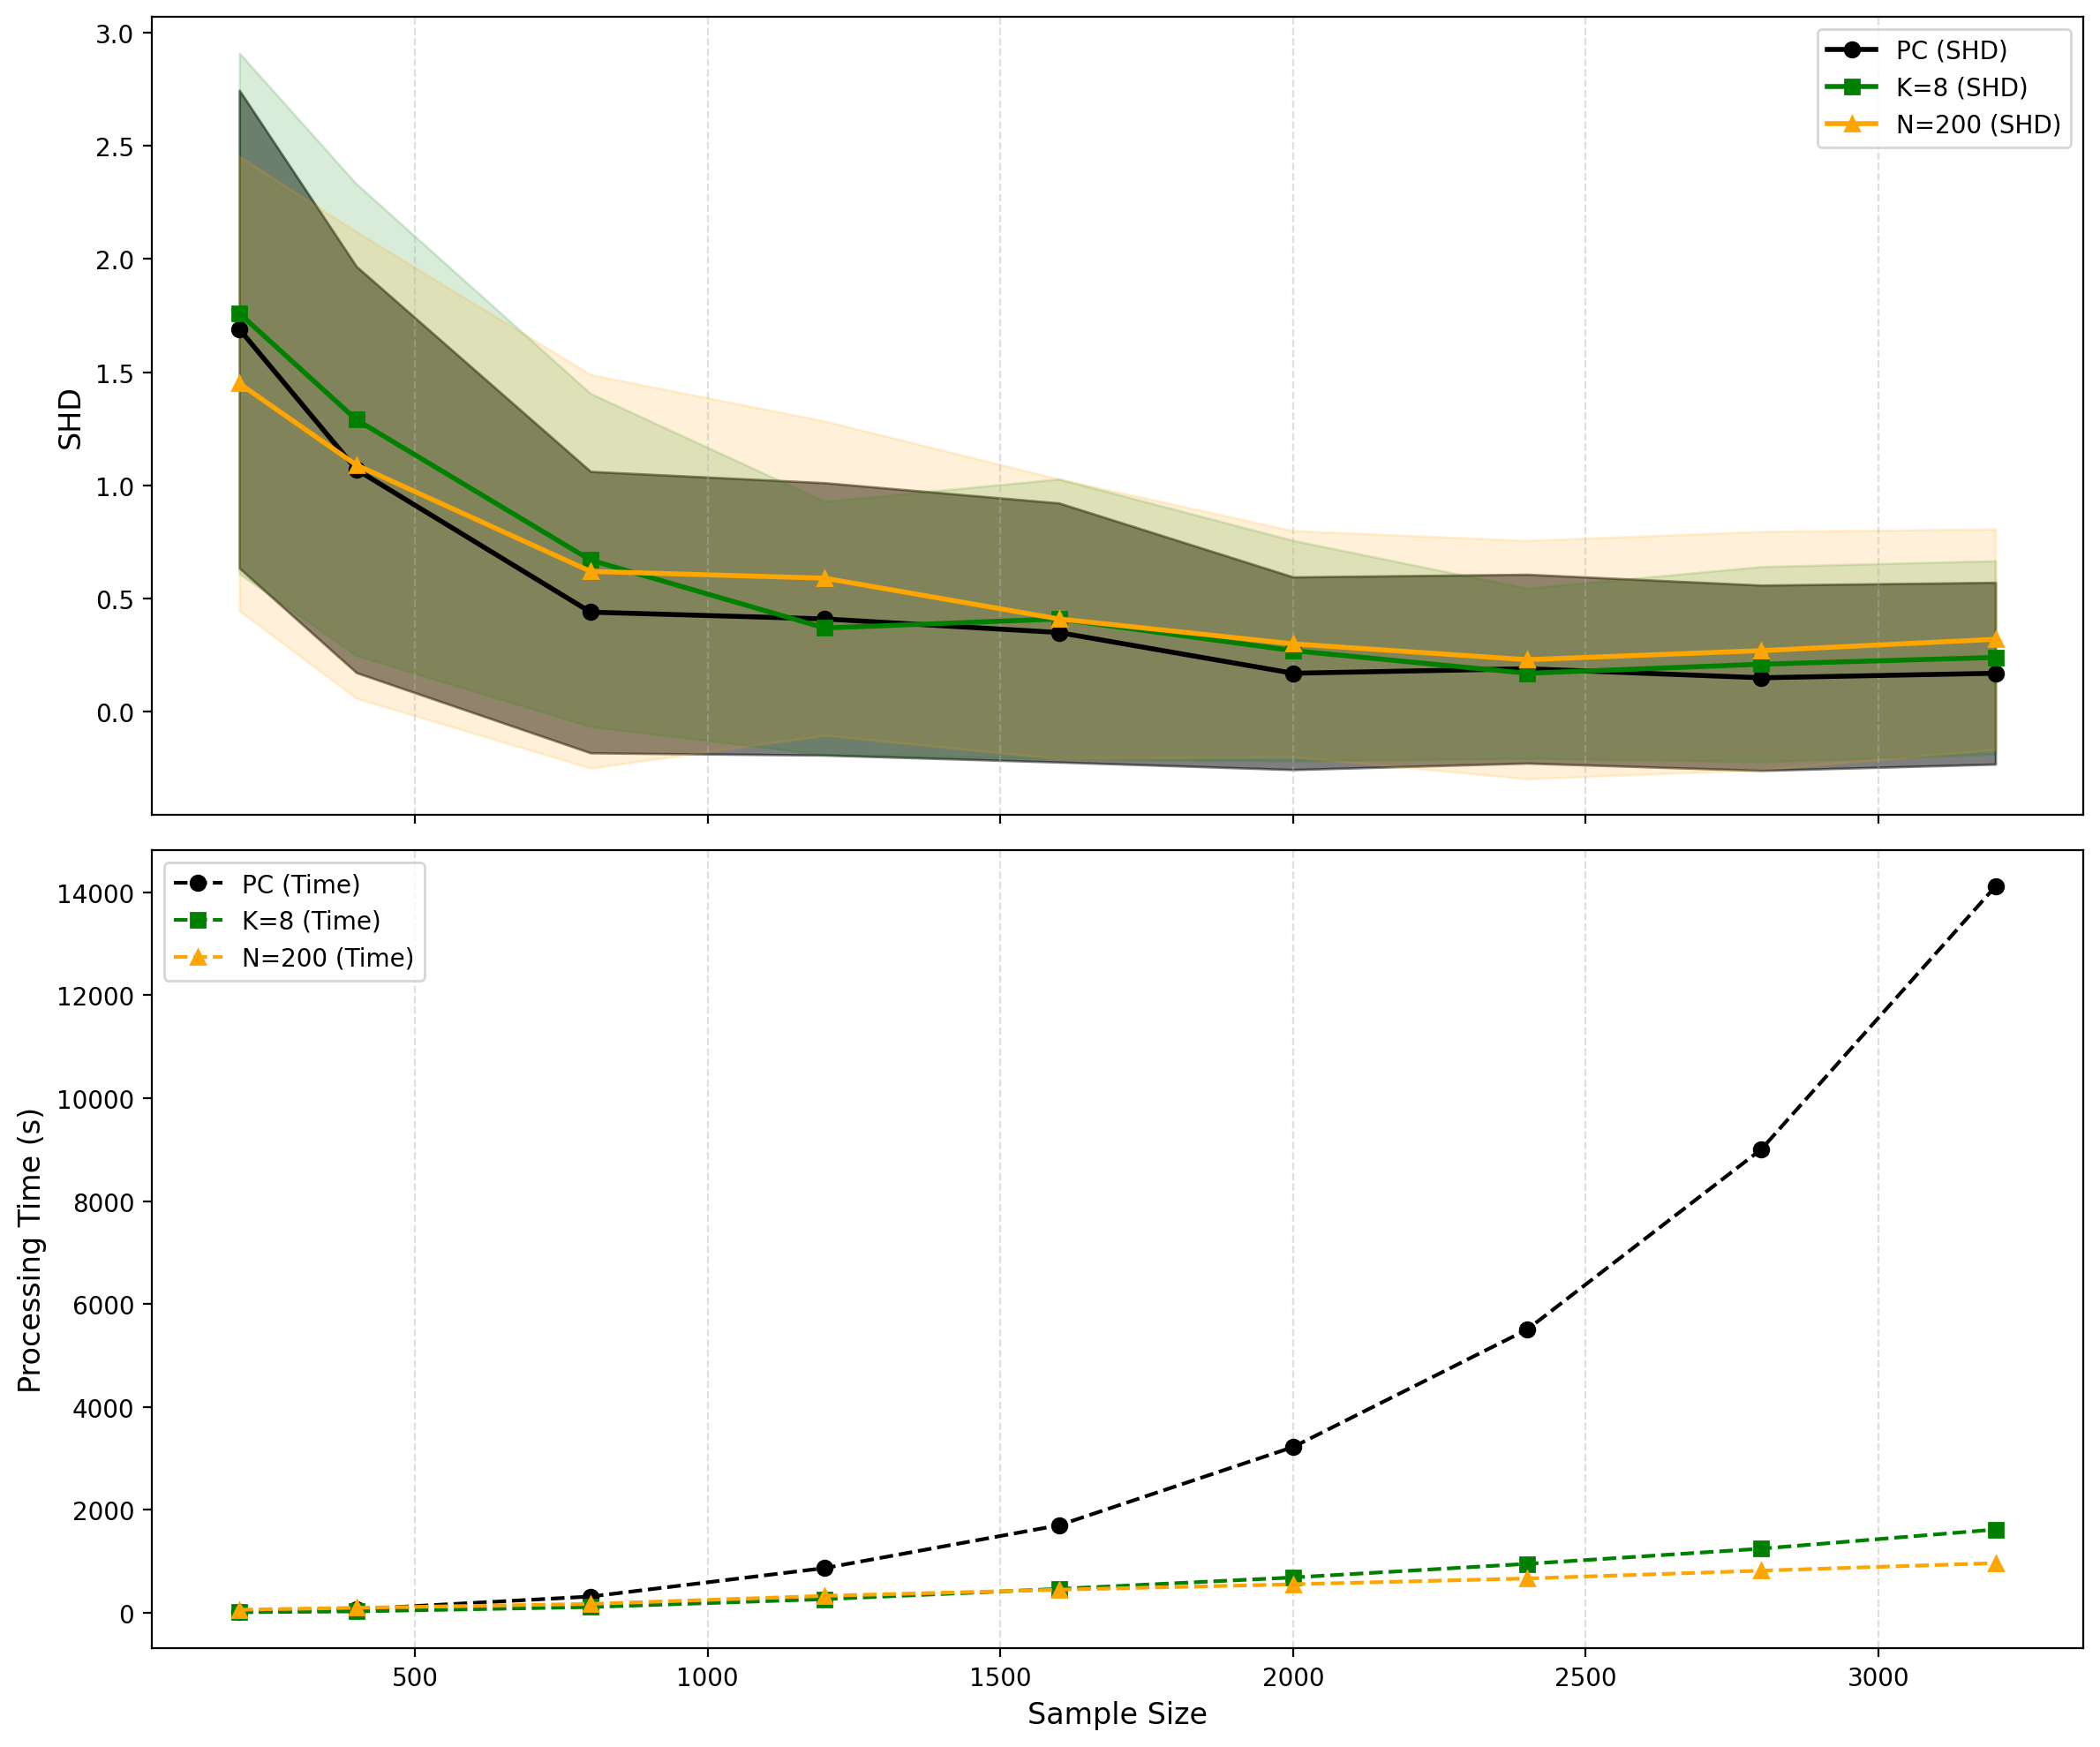

In [73]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, dpi=200)

ax1.plot(x, pc, marker='o', label='PC (SHD)', color='black', linewidth=2)
ax1.fill_between(x, np.array(pc) - np.array(std_pc), np.array(pc) + np.array(std_pc), 
                 color='black', alpha=0.5)
ax1.plot(x, ek8, marker='s', label='K=8 (SHD)', color='green', linewidth=2)
ax1.fill_between(x, np.array(ek8) - np.array(std_ek8), np.array(ek8) + np.array(std_ek8), 
                 color='green', alpha=0.15)
ax1.plot(x, en200, marker='^', label='N=200 (SHD)', color='orange', linewidth=2)
ax1.fill_between(x, np.array(en200) - np.array(std_en200), np.array(en200) + np.array(std_en200), 
                 color='orange', alpha=0.15)
ax1.set_ylabel('SHD', fontsize=12)
ax1.legend(fontsize=10, loc='upper right')
ax1.grid(axis='x', linestyle='--', alpha=0.4)

ax2.plot(x, time_pc, marker='o', label='PC (Time)', color='black', linestyle='--')
ax2.plot(x, time_ek8, marker='s', label='K=8 (Time)', color='green', linestyle='--')
ax2.plot(x, time_en200, marker='^', label='N=200 (Time)', color='orange', linestyle='--')
ax2.set_xlabel('Sample Size', fontsize=12)
ax2.set_ylabel('Processing Time (s)', fontsize=12)
ax2.legend(fontsize=10, loc='upper left')
ax2.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()

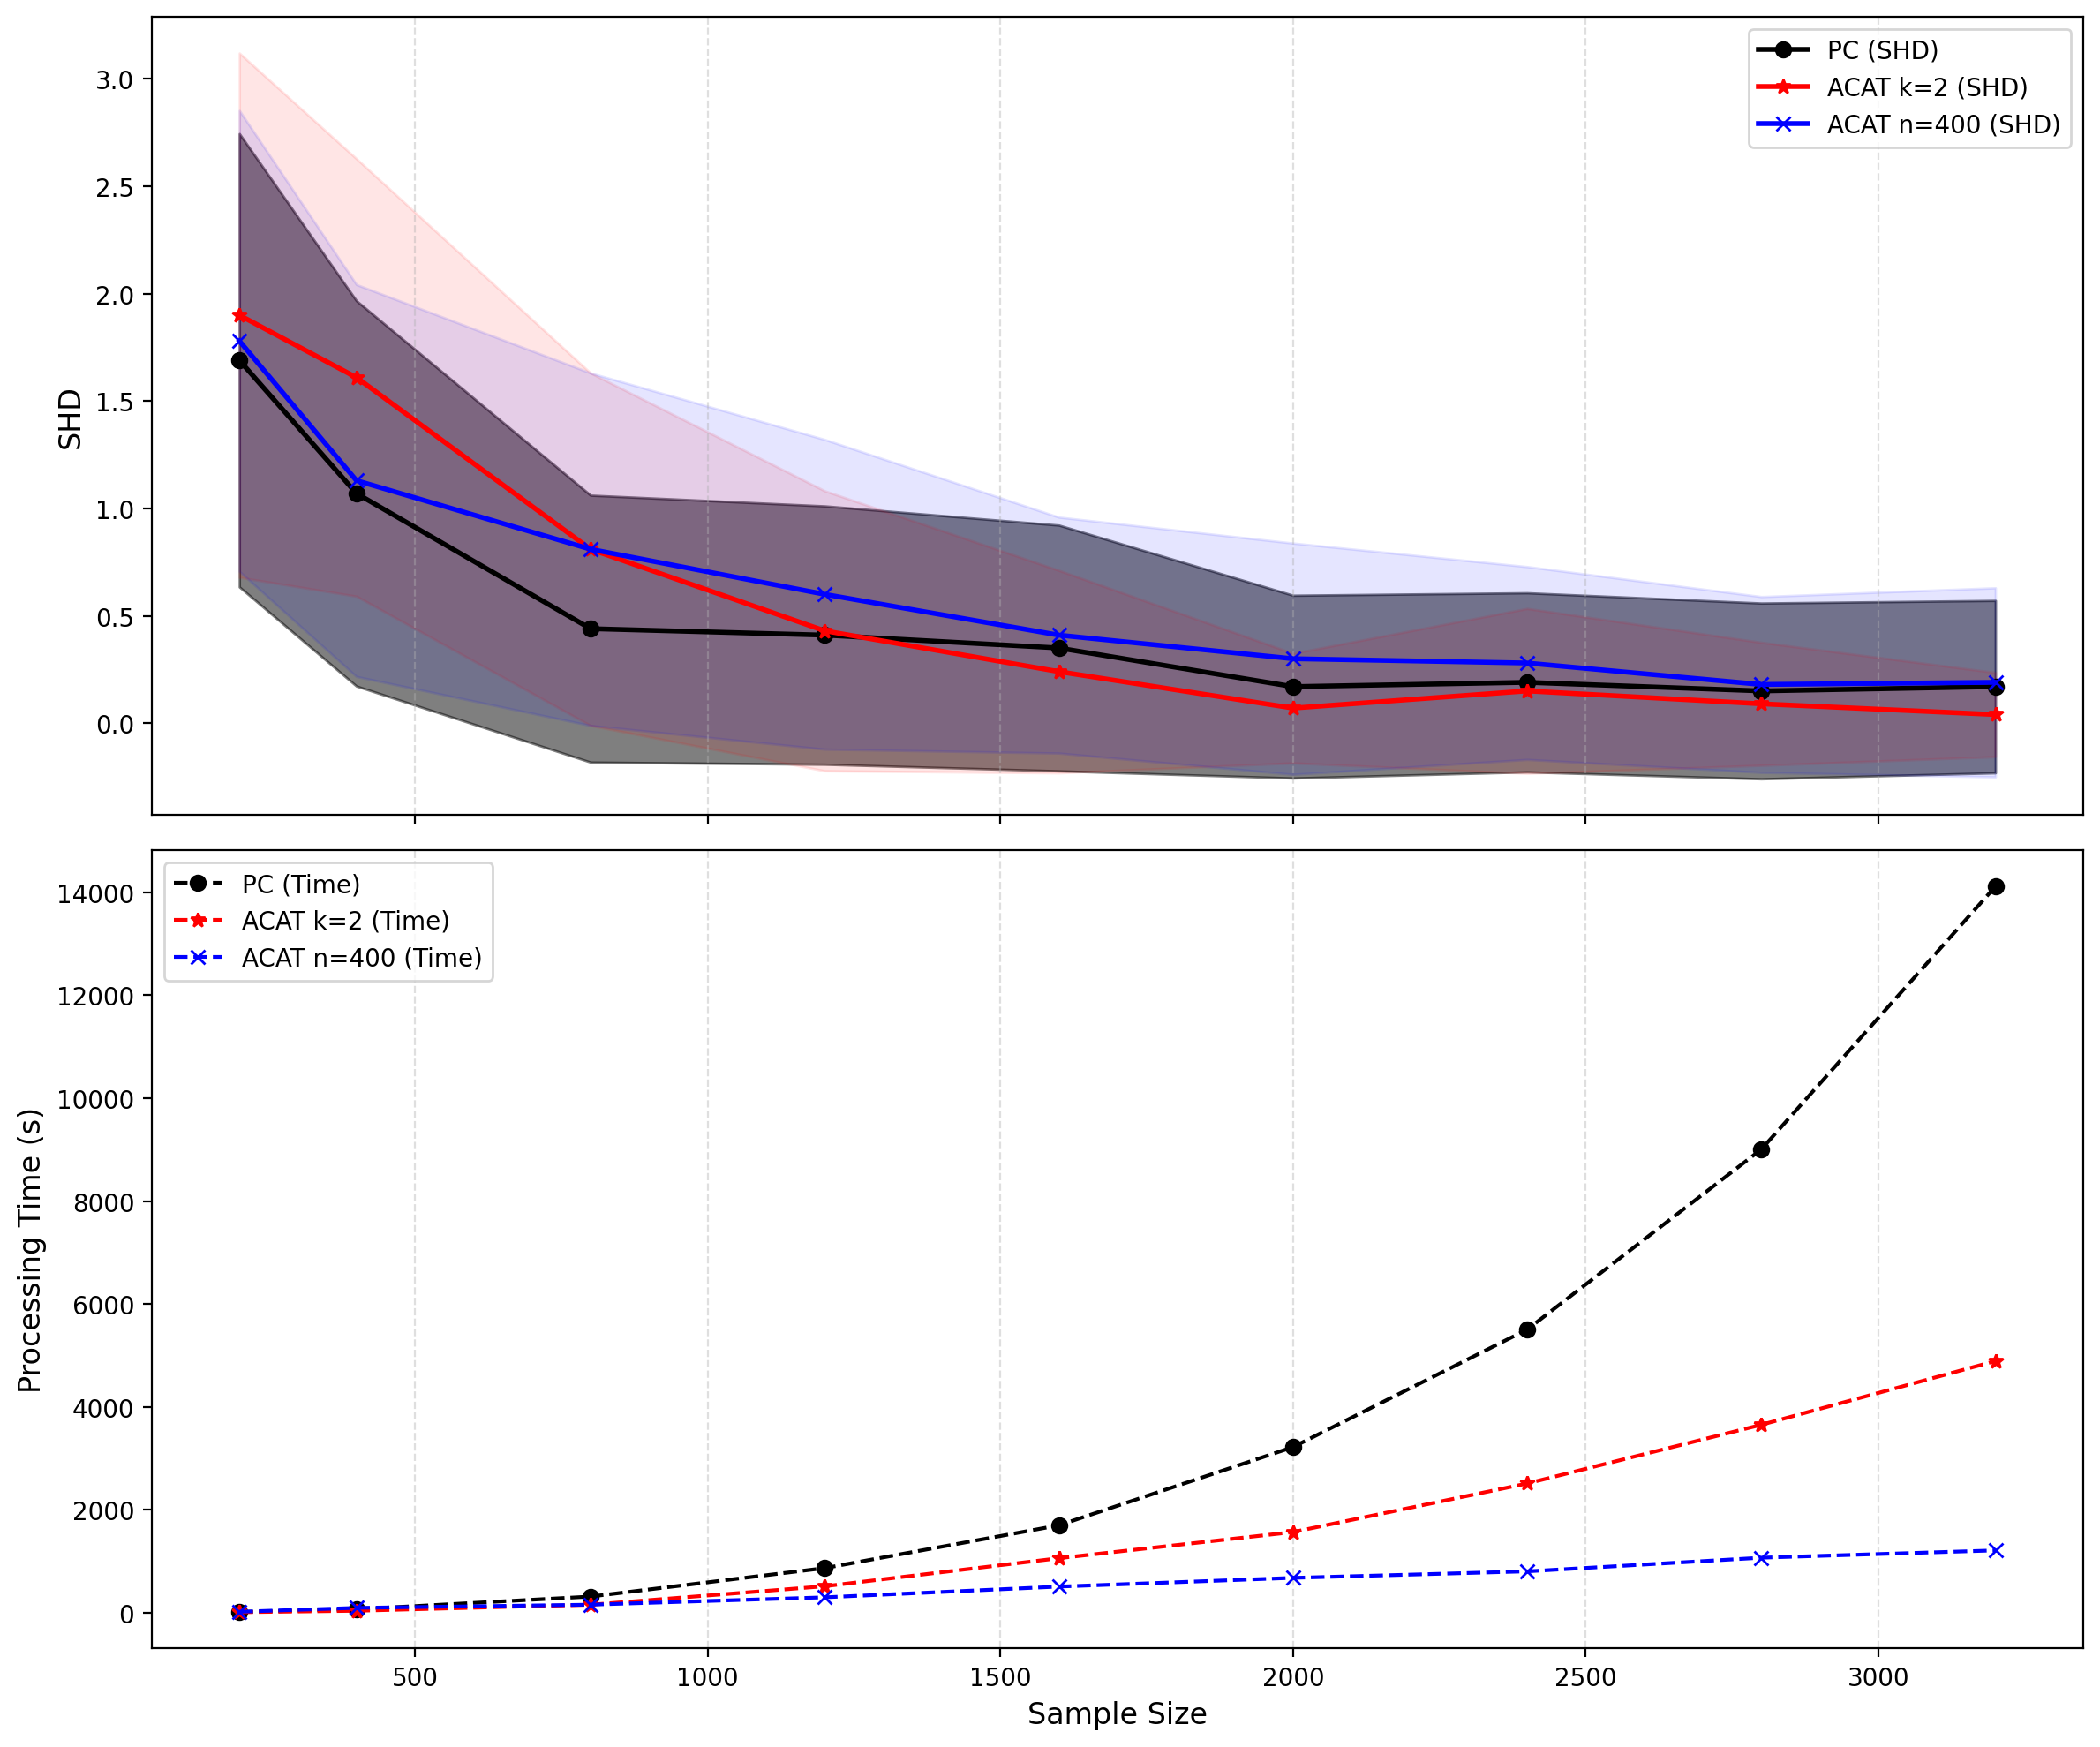

In [74]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True, dpi=200)

ax1.plot(x, pc, marker='o', label='PC (SHD)', color='black', linewidth=2)
ax1.fill_between(x, np.array(pc) - np.array(std_pc), np.array(pc) + np.array(std_pc), 
                 color='black', alpha=0.5)
ax1.plot(x, ak2, marker='*', label='ACAT k=2 (SHD)', color='red', linewidth=2)
ax1.fill_between(x, np.array(ak2) - np.array(std_ak2), np.array(ak2) + np.array(std_ak2), 
                 color='red', alpha=0.1)
ax1.plot(x, an200, marker='x', label='ACAT n=400 (SHD)', color='blue', linewidth=2)
ax1.fill_between(x, np.array(an200) - np.array(std_an200), np.array(an200) + np.array(std_an200), 
                 color='blue', alpha=0.1)
ax1.set_ylabel('SHD', fontsize=12)
ax1.legend(fontsize=10, loc='upper right')
ax1.grid(axis='x', linestyle='--', alpha=0.4)

ax2.plot(x, time_pc, marker='o', label='PC (Time)', color='black', linestyle='--')
ax2.plot(x, time_ak2, marker='*', label='ACAT k=2 (Time)', color='red', linestyle='--')
ax2.plot(x, time_an200, marker='x', label='ACAT n=400 (Time)', color='blue', linestyle='--')
ax2.set_xlabel('Sample Size', fontsize=12)
ax2.set_ylabel('Processing Time (s)', fontsize=12)
ax2.legend(fontsize=10, loc='upper left')
ax2.grid(axis='x', linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()